# Bayesian inference of regression model punctuated with outliers

## Introduction

This notebook was inspired by an idea to model the cost of a gas central heating system by considering factors that would likely impact the gas used to warm a detached house.

It is assumed that the amount of gas used on a given day is dependent on the (average) outside air temperature. The occupants of the house occassionally use more gas than normal, e.g. to boosting the thermostat or having a longer shower.

In [1]:
# Import the required libraries
library(ggplot2)
library(MCMCpack)
library(MCMCvis)
library(reshape2)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=20, repr.plot.height=10)

Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2021 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## Model

Energy usage cannot be negative (as it is assumed there are no mechanisms to put gas back into the distribution network). Therefore, a probability distribution is required that is positive. The Gamma distribution was chosen because it approximates a normal distribution when the mean is sufficiently far away from zero.

### Gamma distribution

In [2]:
x <- seq(from = 0, to = 20, by = 0.1)
alpha_values <- c(1,1,2, 7, 40)
beta_values <- c(0.5, 1, 1, 2, 5)

In [3]:
# Matrix of x values and associated densities of the Gamma distribution
m = matrix(0.0, nrow=length(x), ncol=length(alpha_values)+1)
m[,1] <- x

# Labels for plotting
labels = c()

for (parameter_set in 1:length(alpha_values)) {
    a_value = alpha_values[parameter_set]
    b_value = beta_values[parameter_set]
    
    m[,parameter_set + 1] <- dgamma(x, shape=a_value, rate=b_value)
    #labels = c(labels, expression(paste(alpha, "=", a_value, ", ", beta, "=", b_value)))
    
    labels = c(labels, bquote(alpha ~ "=" ~ .(a_value) ~ ", " ~ beta ~ "=" ~ .(b_value)))
}

In [4]:
# Convert the matrix to a dataframe
df <- as.data.frame(m)
colnames(df)[1] <- "x"

# Melt the dataframe
d <- melt(df, id.vars="x")

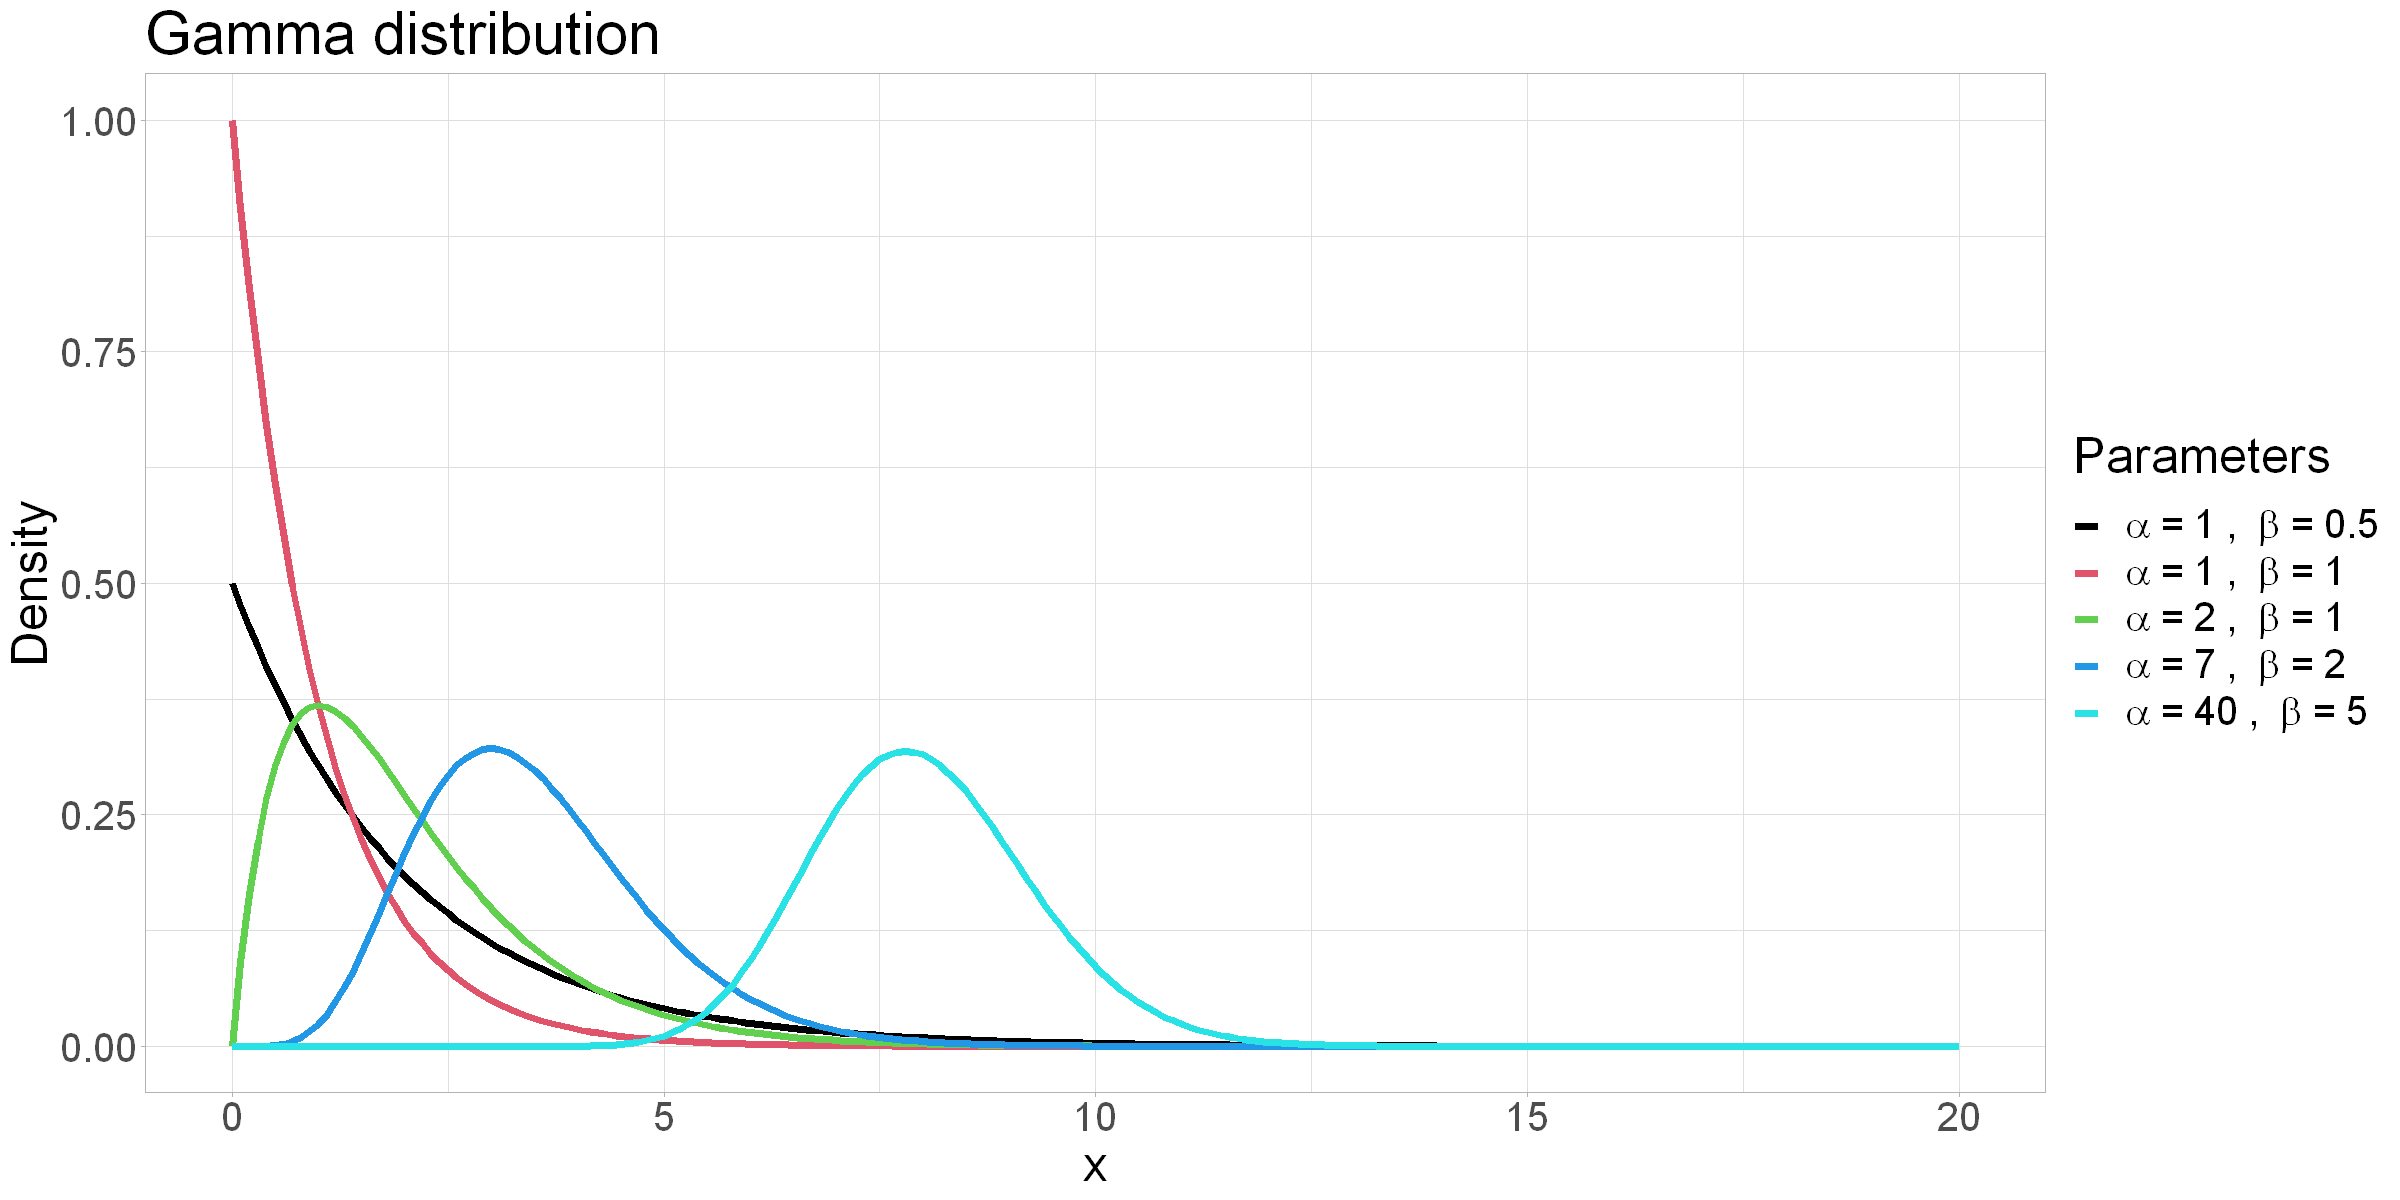

In [5]:
theme_set(theme_light())
ggplot(data = d, aes(x, value, col=variable)) +
    geom_line(size=2) +
    labs(colour = "Parameters") +
    scale_color_manual(labels = labels, values=1:length(alpha_values)) +
    theme(text = element_text(size=30)) +
    ggtitle("Gamma distribution") +
    ylab("Density")

### Generative model

In [6]:
# Temperature range
t_values <- seq(from = 0, to = 20, by = 0.1)

# Rate parameter
rate = 2

num_points_per_temp <- 10

all_t_values <- c()
all_sample_values <- c()

for (t in t_values) {
    for (i in 1:num_points_per_temp) {
        
        alpha_value <- max(-4*t + 70, 0) * rate
        
        sample <- rgamma(n=1, shape=alpha_value, rate=rate)
        
        all_t_values <- c(all_t_values, t)
        all_sample_values <- c(all_sample_values, sample)
    }
}

df <- data.frame(t=all_t_values, y=all_sample_values)

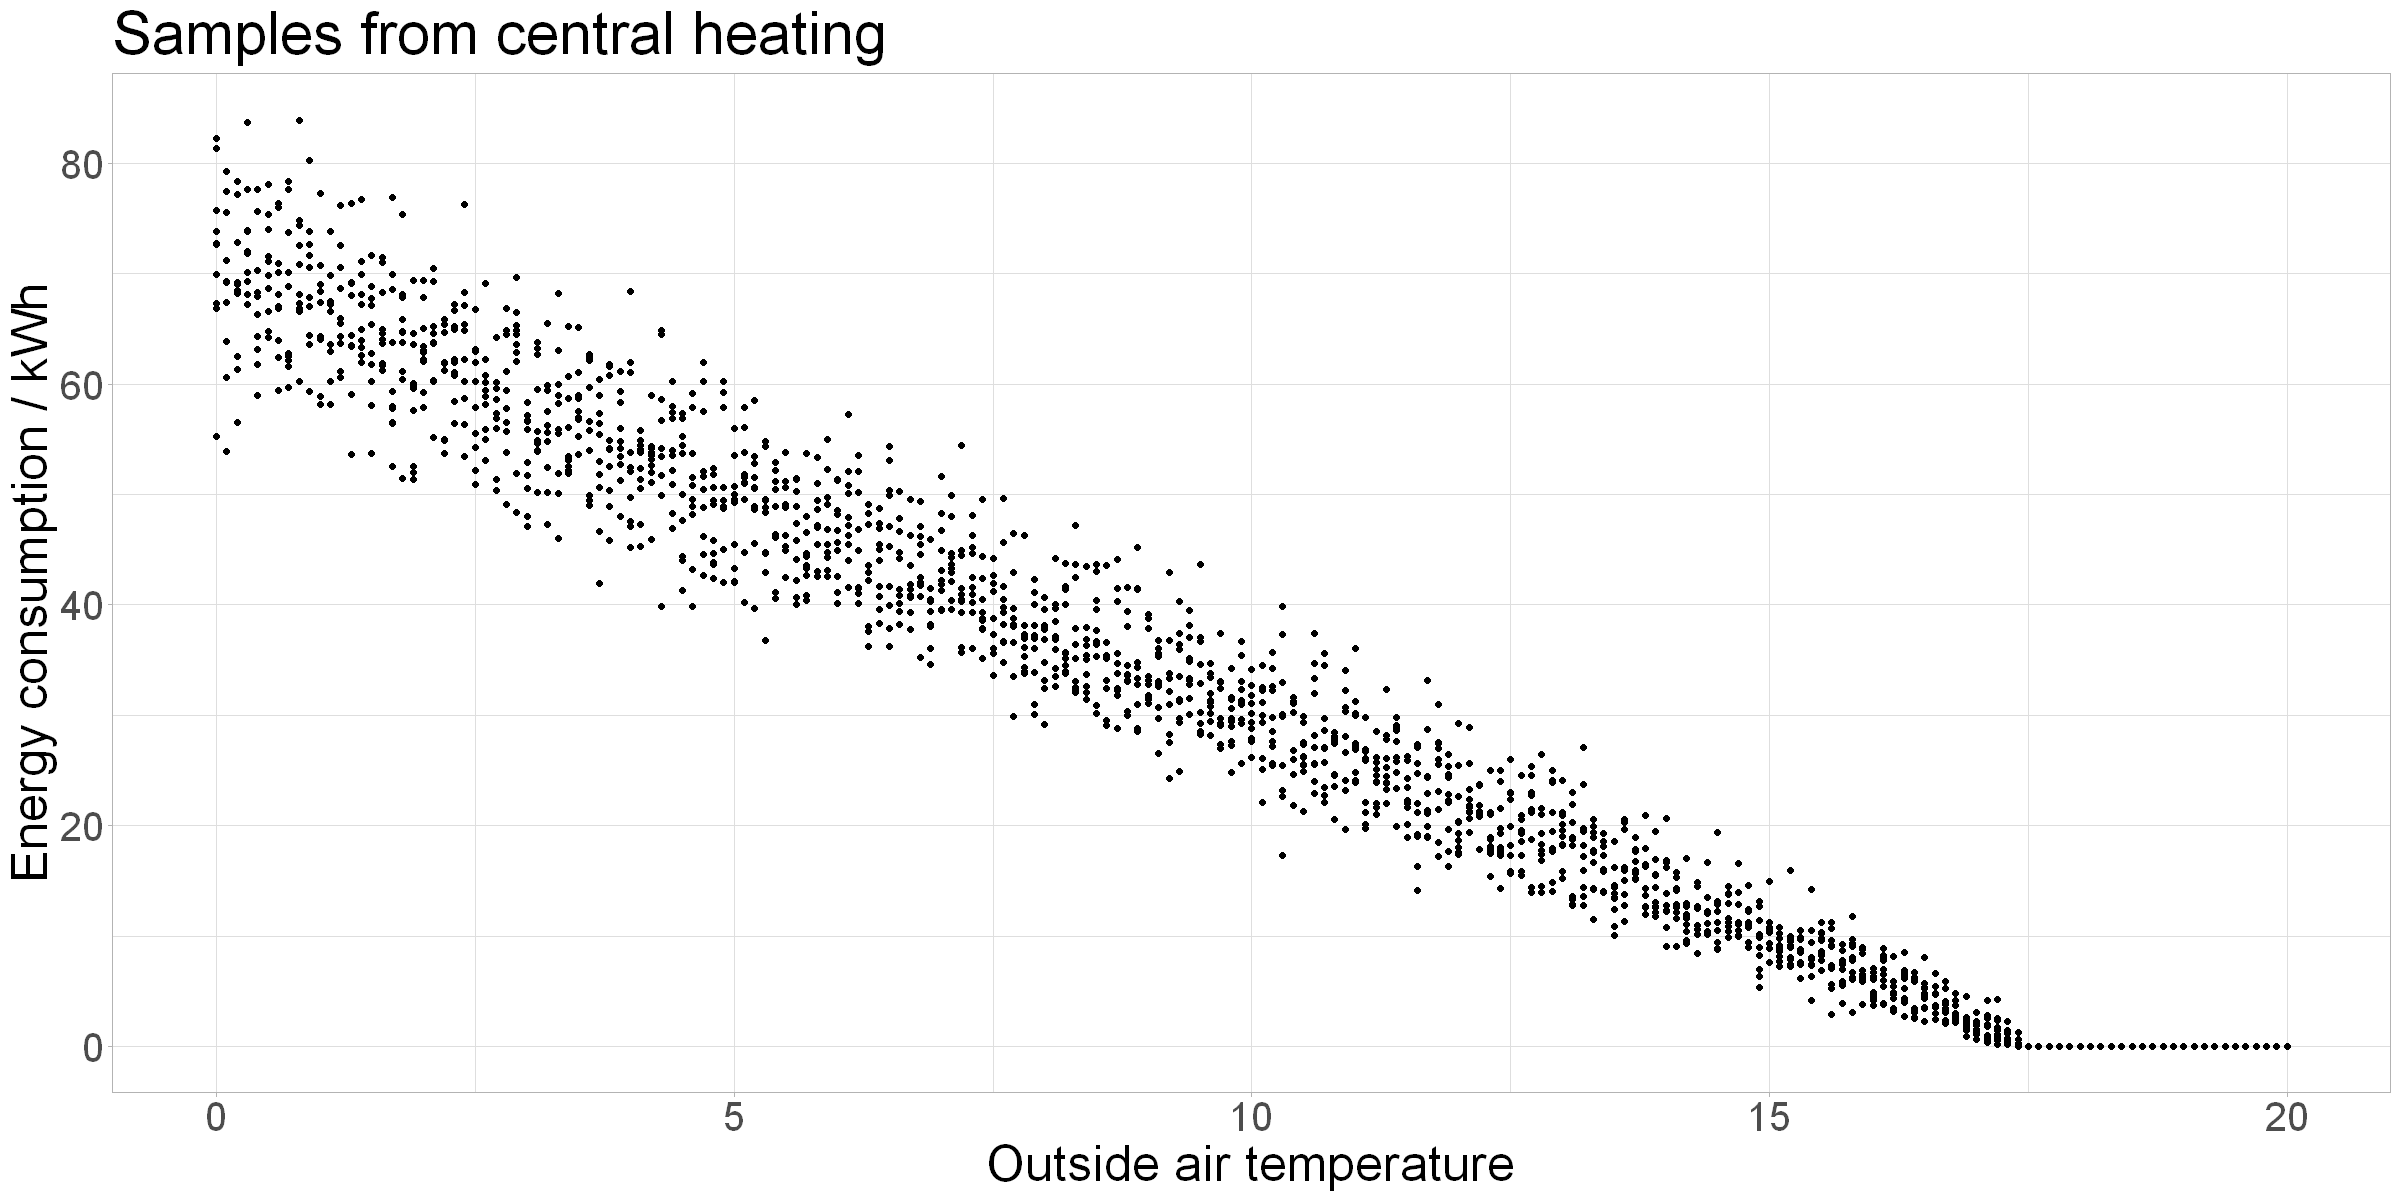

In [7]:
theme_set(theme_light())
ggplot(data = df, aes(t, y)) +
    geom_point() +
    theme(text = element_text(size=30)) +
    ggtitle("Samples from central heating") +
    xlab("Outside air temperature") +
    ylab("Energy consumption / kWh")

In [8]:
# Mean hot water energy consumption in kWh
mean_hot_water_energy <- 3.0

# Probability of an outlier day
p_outlier <- 0.2

# Extra hot water usage on an outlier day in kWh
extra_hot_water_energy <- 2.0

# Number of days to model
num_days <- 100

In [9]:
outlier_day <- rbinom(num_days, 1, p_outlier)

In [10]:
hot_water_energy_usage <- c()
outlier_day <- rbinom(num_days, 1, p_outlier)
rate_water <- 10
alpha_values <- (rep(mean_hot_water_energy, num_days) + outlier_day * extra_hot_water_energy) * rate_water

water_energy_usage <- c()

for (d in 1:num_days) {
    water_energy_usage <- c(water_energy_usage, rgamma(1, shape=alpha_values[d], rate=rate_water))
}

In [11]:
df <- data.frame(day=1:num_days, y=water_energy_usage, outlier=outlier_day)

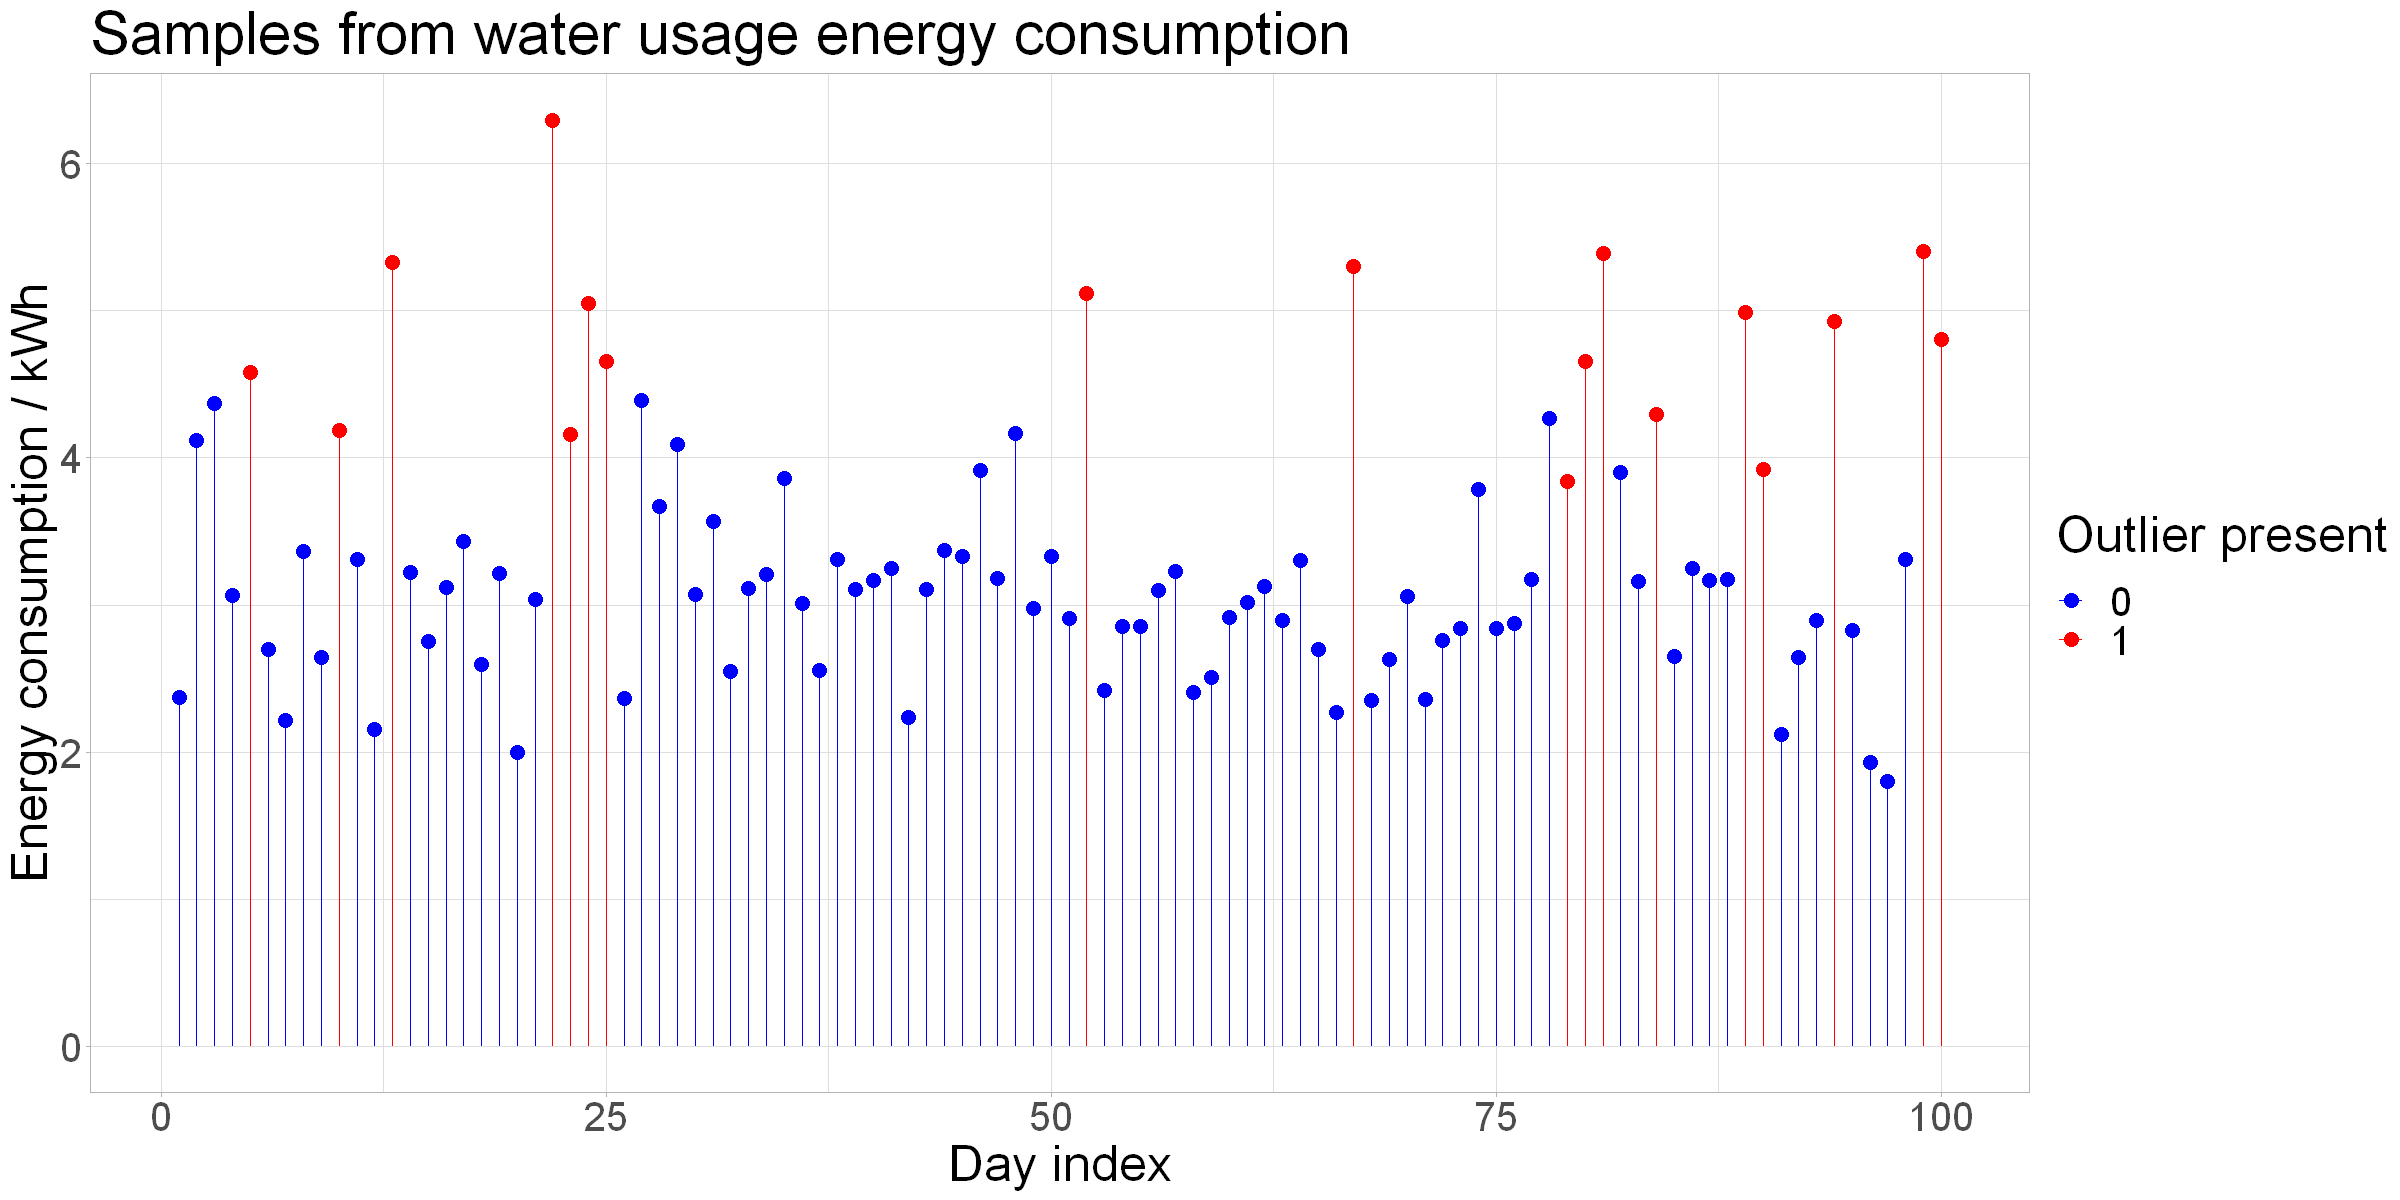

In [12]:
ggplot(data = df, aes(day, y, color=as.factor(outlier))) +
    geom_point(size=4) +
    theme(text = element_text(size=30)) +
    ggtitle("Samples from water usage energy consumption") +
    xlab("Day index") +
    ylab("Energy consumption / kWh") +
    scale_color_manual(values=c("blue", "red")) +
    labs(colour = "Outlier present") +
    geom_segment(aes(day, y,xend=day,yend=y-y))

The component that models the central heating is given by

$$
e_{ch} \sim \text{Gamma}( \alpha_{ch}, \beta_{ch} )
$$

where

$$
\alpha_{ch} = \max \Big( \beta_{ch} ( \delta t + c) , 0 \Big).
$$

The probability that there is an outlier on a given day is given by $p_{out}$. A sample is drawn from a Bernoulli distribution with $p = p_{out}$. If the sample is $1$ then an outlier occurs.

The component that accounts for the normal hot water usage is given by

$$
e_{hw} \sim \text{Gamma}( \alpha_{hw}, \beta_{hw} )
$$

however, if there is an outlier

$$
e_{hw} \sim \text{Gamma}( \alpha_{hw} + \alpha_{out} , \beta_{hw} )
$$

In the experiment, the outside air temperate is assumed to be approximately constant (as only a limited time period is considered), so the temperate is modelled as a normal distribution.

$$
t \sim N( \mu_t, \sigma_t )
$$

where $\mu_t$ is the mean temperature and $\sigma_t$ is the standard deviation of the temperature.

In [32]:
# Number of days to simulate
num_days <- 30

# Mean and standard deviation of the outside air temperate
mu_t <- 15
sigma_t <- 0.2

# Outside air temperature
t <- rnorm(num_days, mu_t, sigma_t)

# Constants of linear equation to relate central heating gas usage to outside air temperature
delta <- -4.0
c <- 70.0

# Rate of the Gamma distribution for the central heating
beta_ch <- 2

# Vector of alpha_ch values for each day (ensure minimum value is zero)
alpha_ch_vector <- beta_ch*(delta * t + c)
alpha_ch_vector[alpha_ch_vector < 0] = 0

# Energy consumption due to central heating
e_ch <- rep(NA, num_days)
for (d in 1:num_days) {
    e_ch[d] <- rgamma(n=1, shape=alpha_ch_vector[d], rate=beta_ch) 
}

# Probability of an outlier in water usage
p_outlier <- 0.2

# Outlier days
outlier_day <- rbinom(num_days, 1, p_outlier)

# Energy consumption due to hot water
beta_hw <- 10
alpha_hw <- 2.0 * beta_hw
alpha_out <- 5.0 * beta_hw
alpha_hw_days <- rep(alpha_hw, num_days) + outlier_day*alpha_out

e_hw <- rep(NA, num_days)
for (d in 1:num_days) {
    e_hw[d] <- rgamma(1, shape=alpha_hw_days[d], rate=beta_hw)
}

# Total energy usage
e <- e_ch + e_hw

In [33]:
# Dataframe of the values
df <- data.frame(
    day=1:num_days,
    e_ch=e_ch,
    e_hw=e_hw,
    e_total=e,
    outlier=outlier_day
)

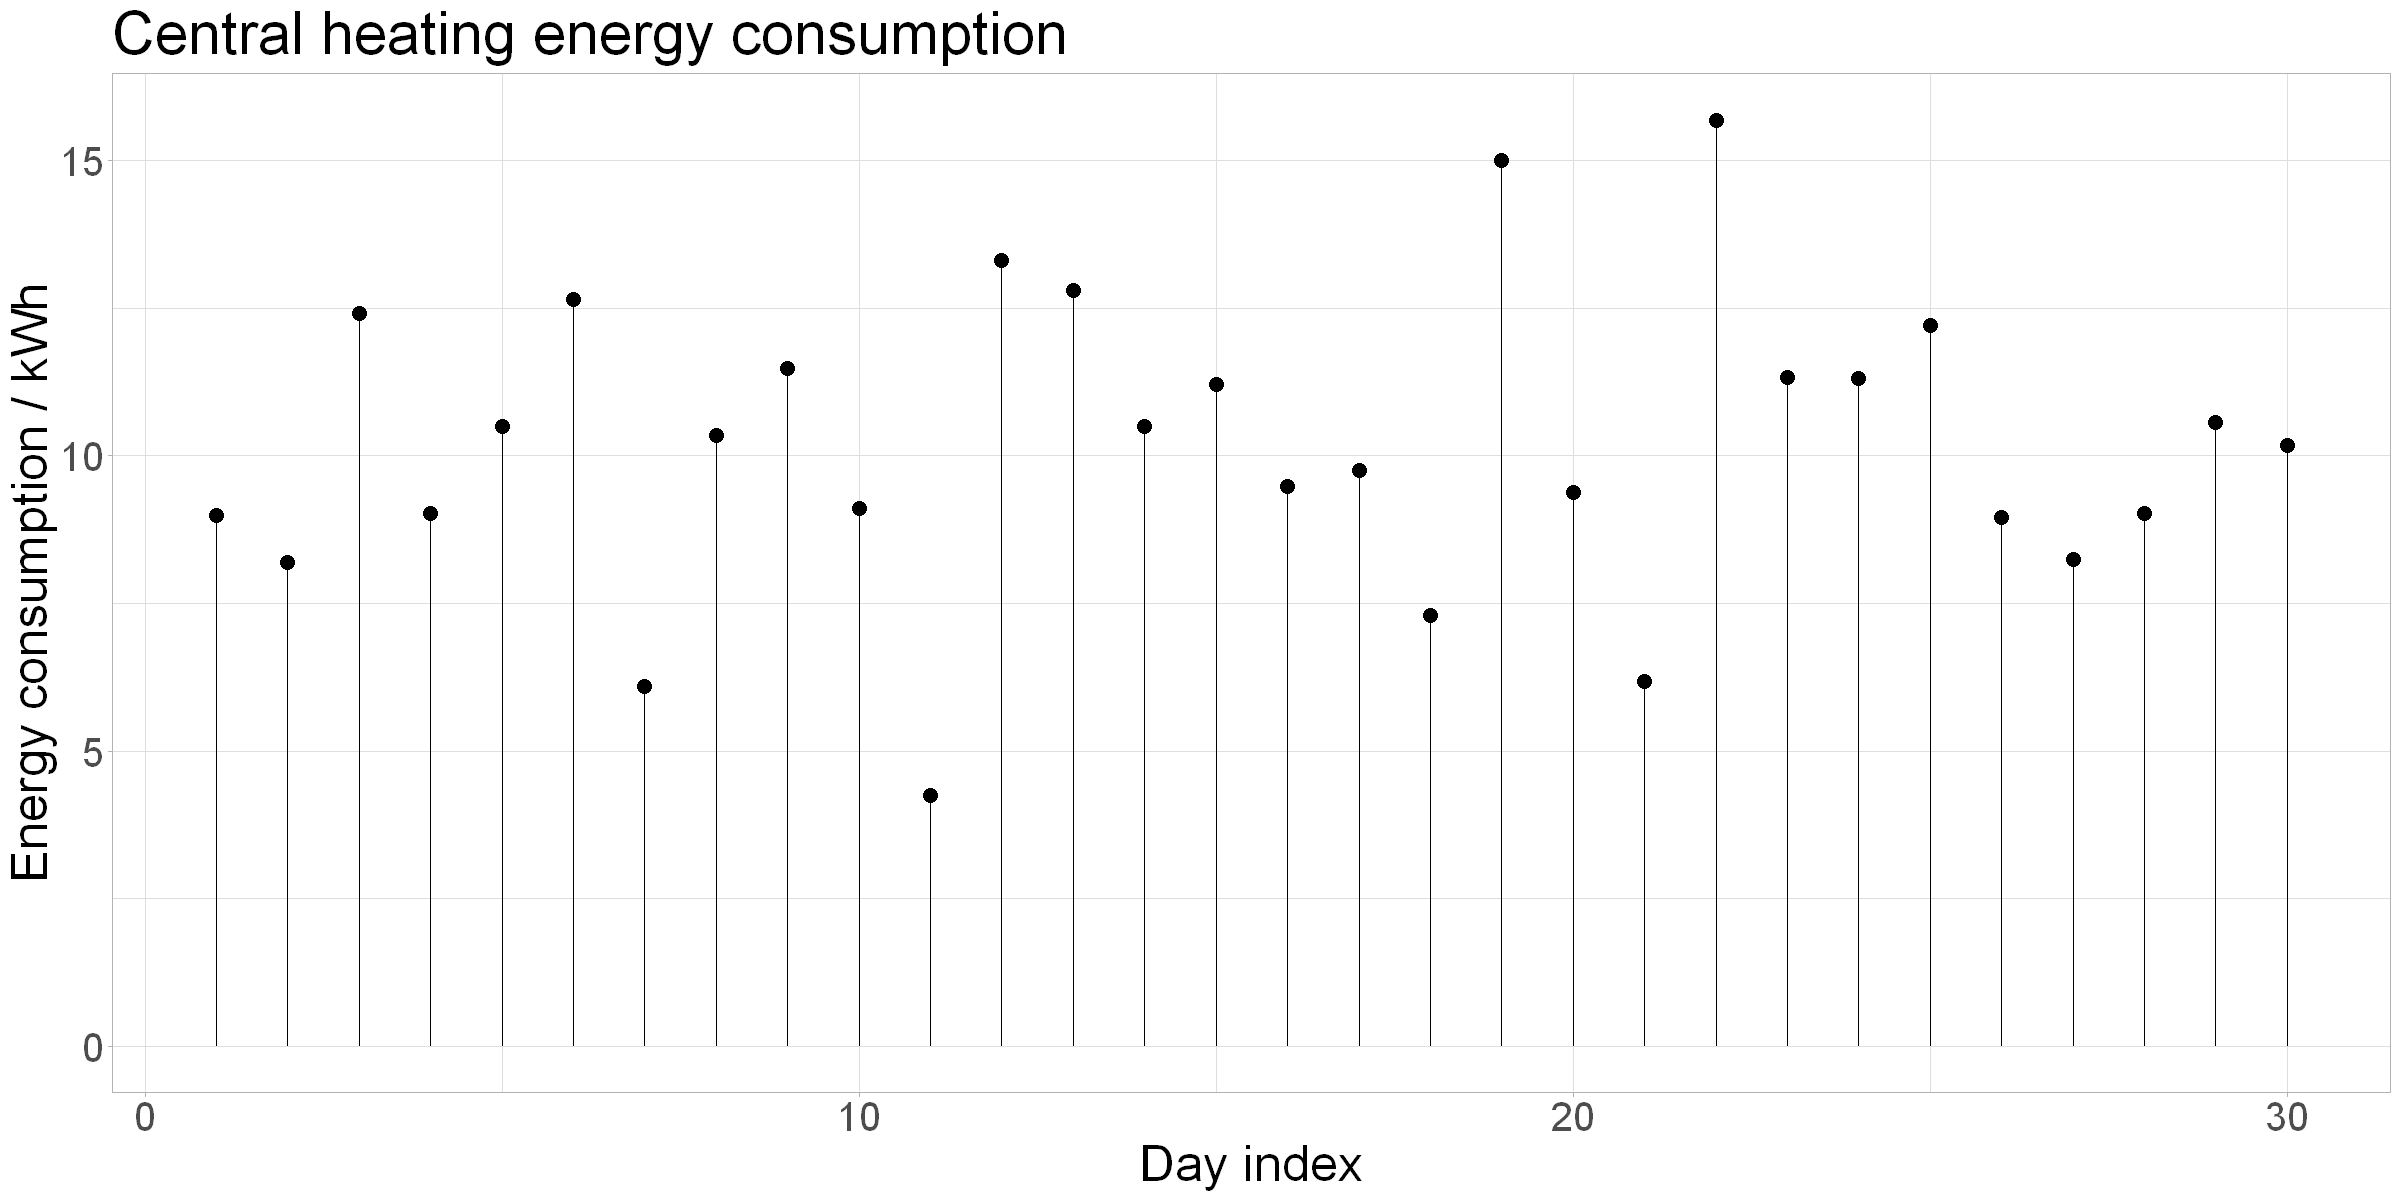

In [34]:
ggplot(data = df, aes(day, e_ch)) +
    geom_point(size=4) +
    theme(text = element_text(size=30)) +
    ggtitle("Central heating energy consumption") +
    xlab("Day index") +
    ylab("Energy consumption / kWh") +
    geom_segment(aes(day, e_ch, xend=day, yend=e_ch-e_ch))

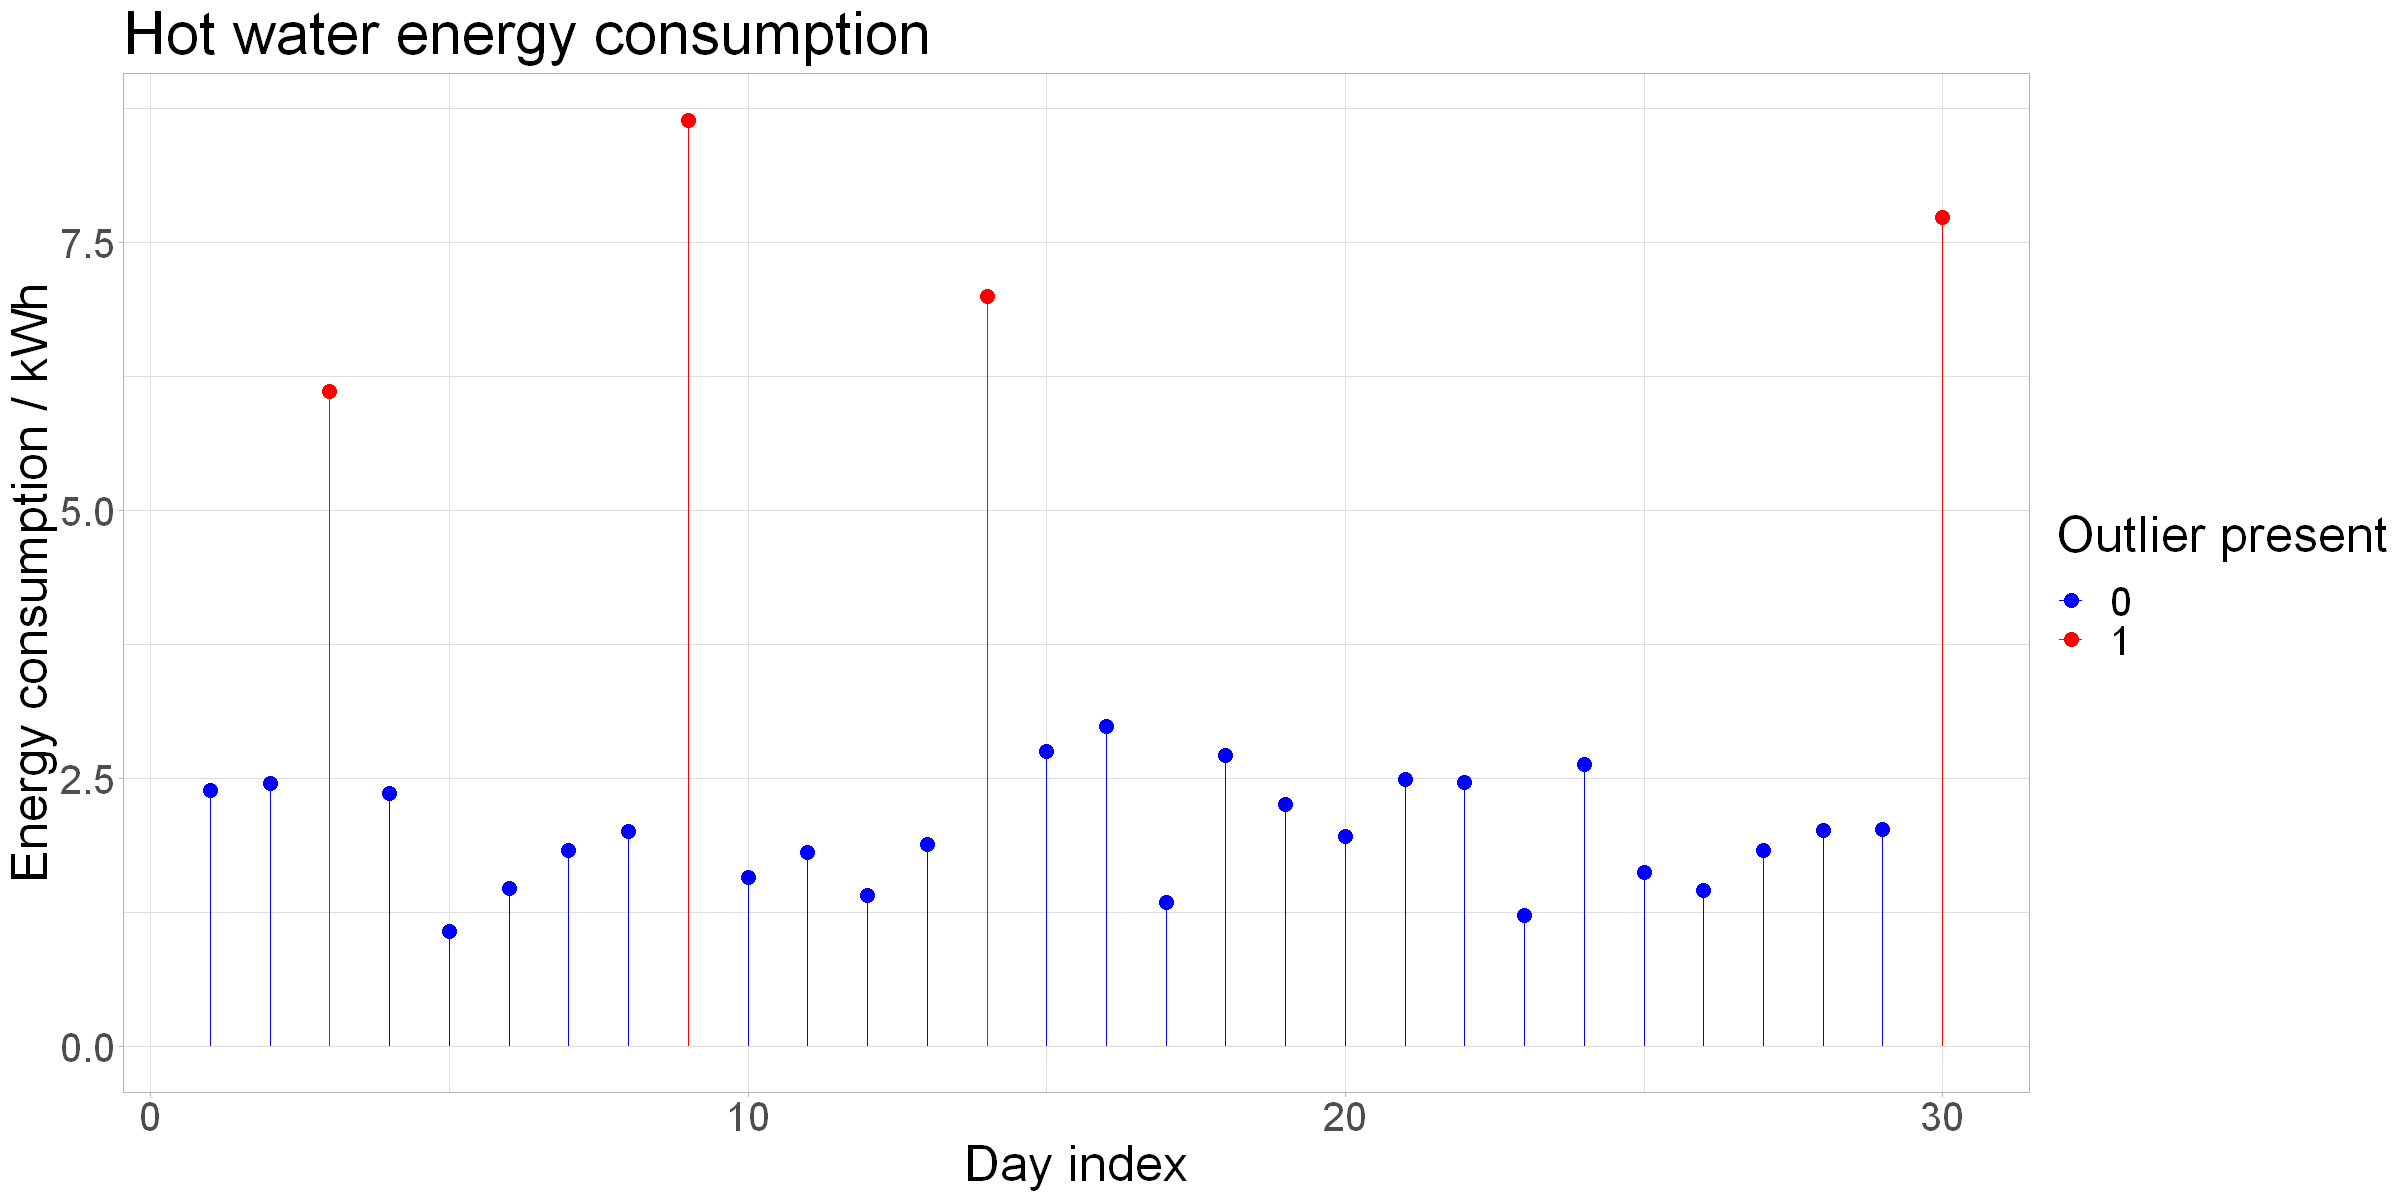

In [35]:
ggplot(data = df, aes(day, e_hw, color=as.factor(outlier))) +
    geom_point(size=4) +
    theme(text = element_text(size=30)) +
    ggtitle("Hot water energy consumption") +
    xlab("Day index") +
    ylab("Energy consumption / kWh") +
    scale_color_manual(values=c("blue", "red")) +
    labs(colour = "Outlier present") +
    geom_segment(aes(day, e_hw, xend=day, yend=e_hw-e_hw))

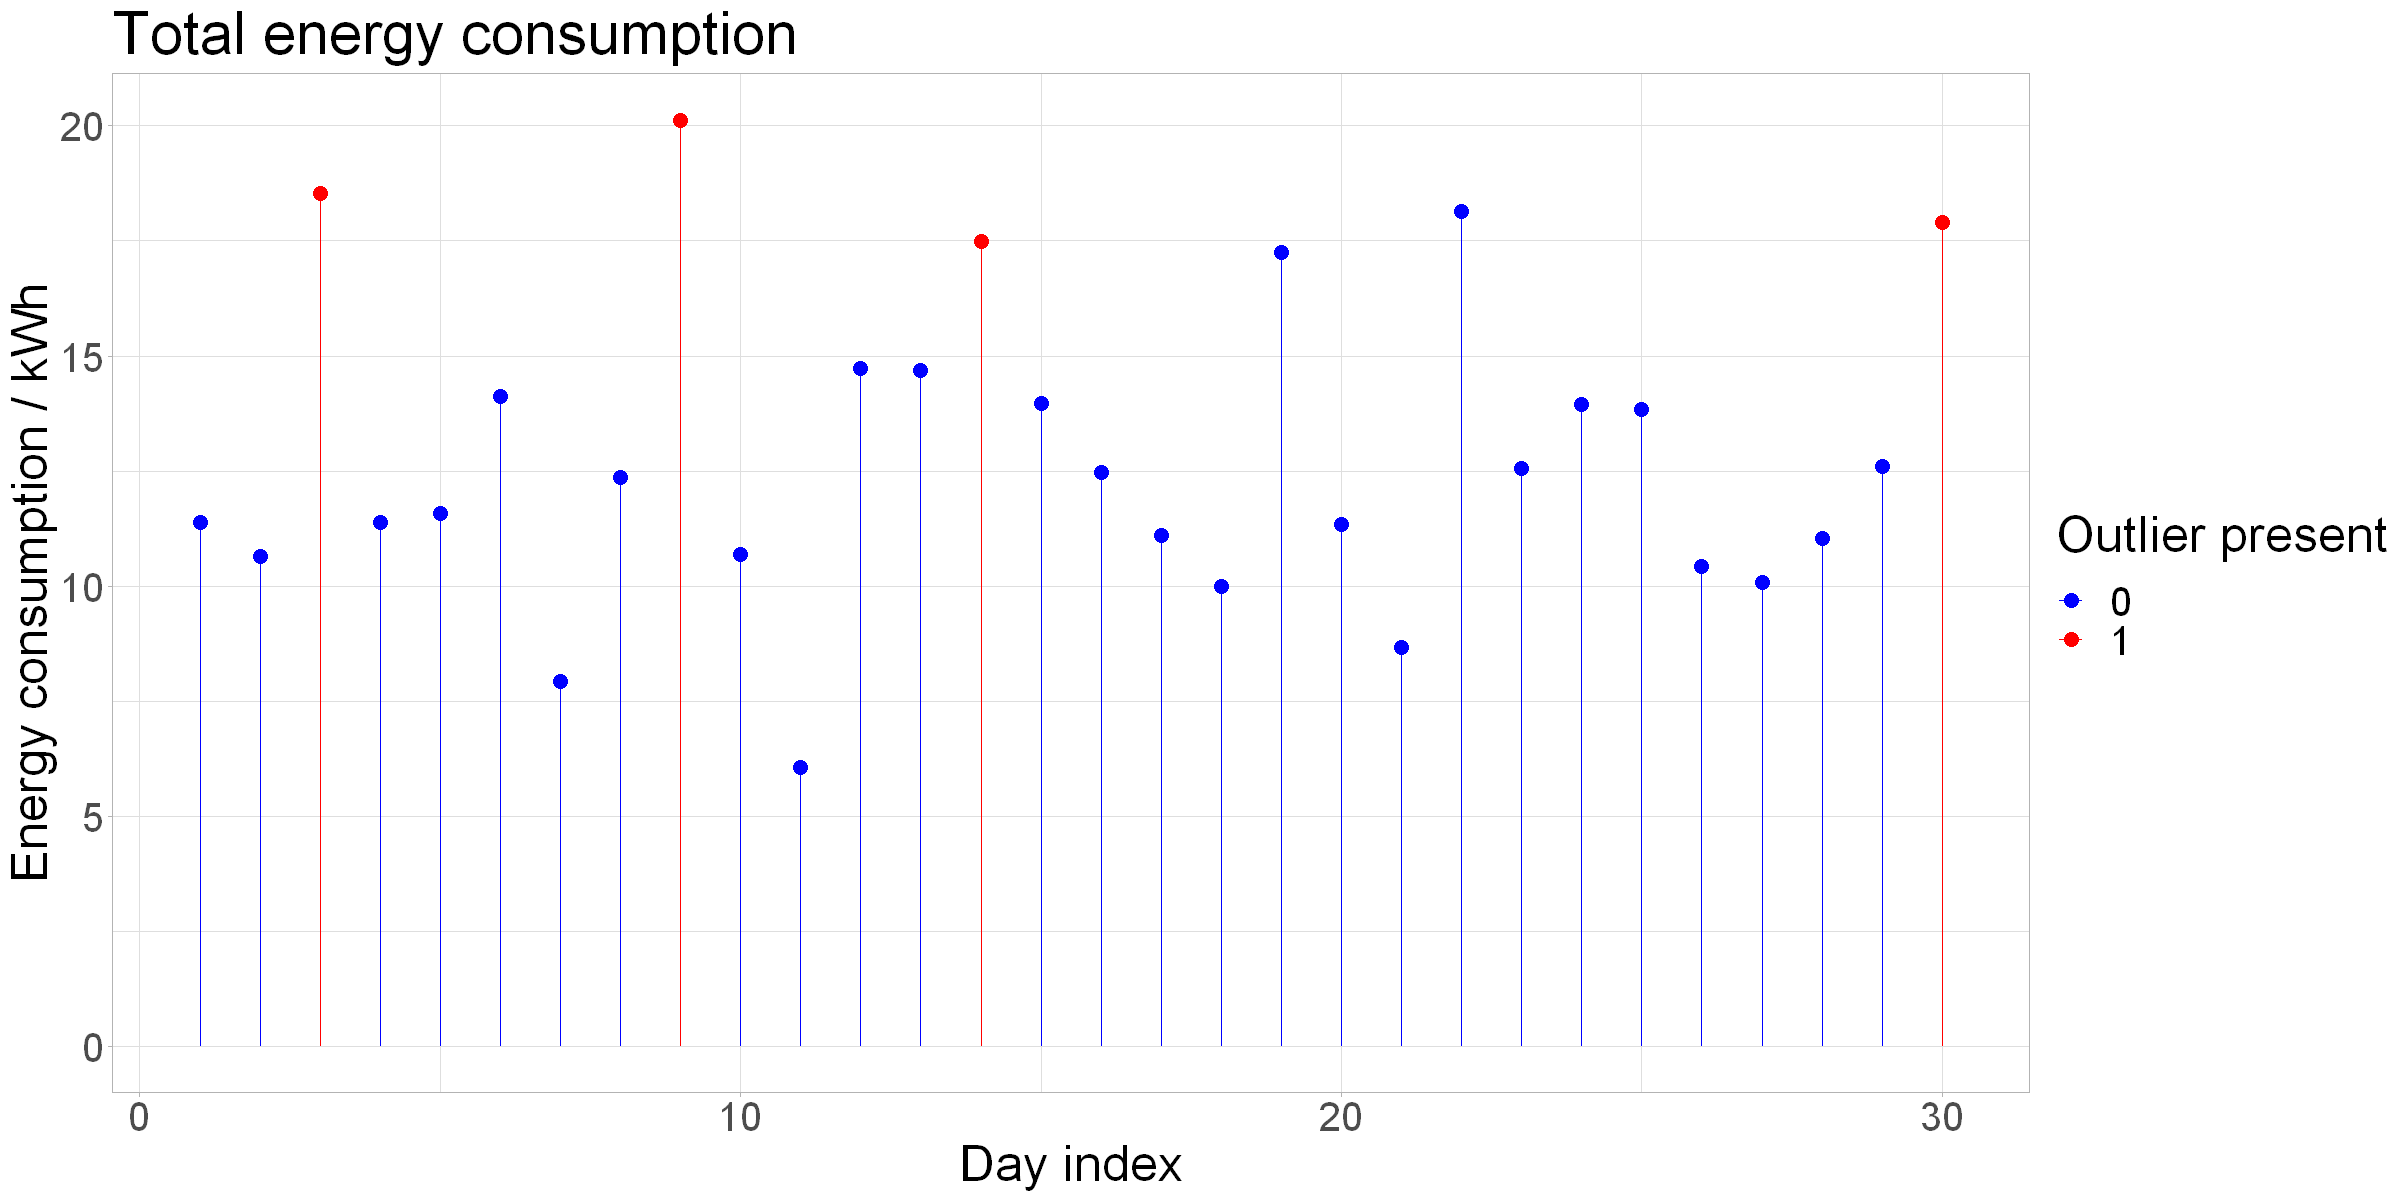

In [36]:
ggplot(data = df, aes(day, e_total, color=as.factor(outlier))) +
    geom_point(size=4) +
    theme(text = element_text(size=30)) +
    ggtitle("Total energy consumption") +
    xlab("Day index") +
    ylab("Energy consumption / kWh") +
    scale_color_manual(values=c("blue", "red")) +
    labs(colour = "Outlier present") +
    geom_segment(aes(day, e_total, xend=day, yend=e_total-e_total))

## Bayesian inference

In [24]:
sd(t)

[1] 0.1566599

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 33
   Total graph size: 72

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
mu_t,14.99,0.03,14.94,14.99,15.06,NA,11463
sigma_t,0.16,0.02,0.13,0.16,0.22,NA,10090


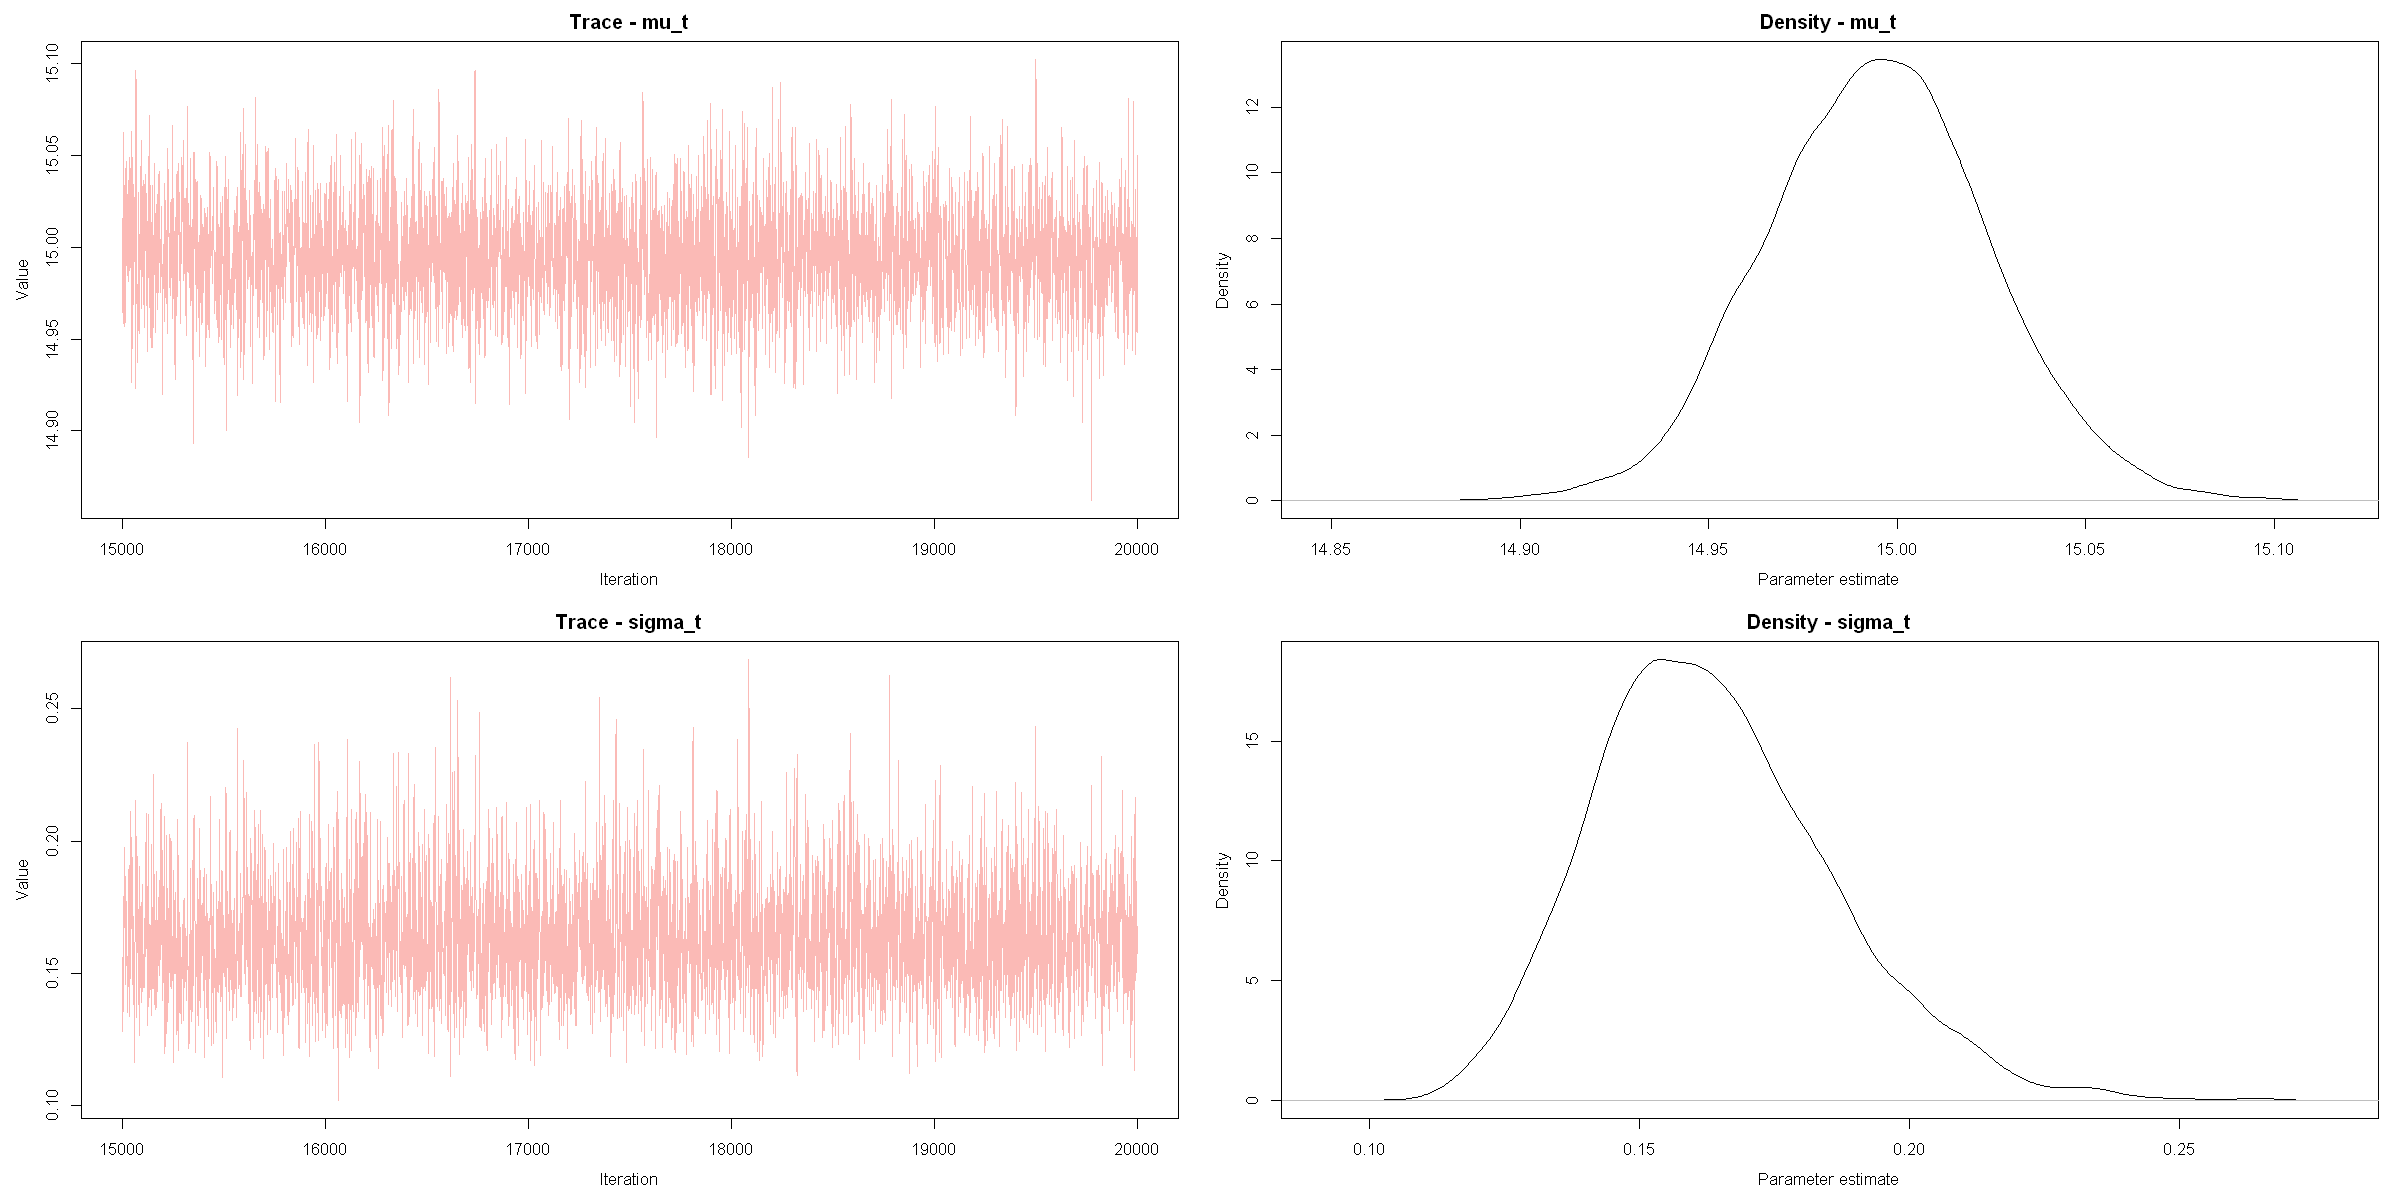

In [31]:
# Infer the parameters of the air temperate model
model_string = "
model {

    mu_t ~ dunif(-10, 35)  # Mean of the air temperature
    sigma_t ~ dexp(0.1)    # Standard deviation of the air temperature

    p_outlier ~ dunif(0, 1)  # Probability of an outlier
    
    for (d in 1:num_days) {
        
        # Outside air temperature
        t[d] ~ dnorm(mu_t, 1/(sigma_t*sigma_t))  # NB. Precision = 1/(sigma^2)

        # Outlier on day d
        outlier[d] ~ dbern(p_outlier)
        
        
    }

    
    
}
"

model = jags.model(textConnection(model_string),
                   data = list(num_days=num_days, t=t))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("mu_t", "sigma_t"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)


MCMCtrace(samp,
          pdf=FALSE)